# GPU-accelerated image processing using CUPY and CUCIM
Processing large images with python can take time. In order to accelerate processing, graphics processing units (GPUs) can be exploited, for example using [NVidia CUDA](https://en.wikipedia.org/wiki/CUDA). For processing images with CUDA, there are a couple of libraries available. We will take a closer look at [cupy](https://cupy.dev/), which brings more general computing capabilities for CUDA compatible GPUs, and [cucim](https://github.com/rapidsai/cucim), a library of image processing specific operations using CUDA. Both together can serve as GPU-surrogate for [scikit-image](https://scikit-image.org/).

See also
* [StackOverflow: Is it possible to install cupy on google colab?](https://stackoverflow.com/questions/49135065/is-it-possible-to-install-cupy-on-google-colab)
* [Cucim example notebooks](https://github.com/rapidsai/cucim/blob/branch-0.20/notebooks/Welcome.ipynb)

Before we start, we need to install CUDA and CUCIM it properly. The following commands make this notebook run in Google Colab.

In [1]:
!curl https://colab.chainer.org/install | sh -

!pip install cucim
!pip install scipy scikit-image cupy-cuda100

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5851      0 --:--:-- --:--:-- --:--:--  5851
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [2]:
import numpy as np
import cupy as cp
import cucim
from skimage.io import imread, imshow
import pandas as pd

In the following, we are using image data from Paci et al shared under  the [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license. See also: https://doi.org/10.17867/10000140 


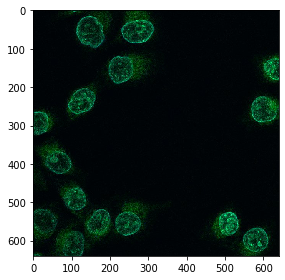

In [3]:
image = imread('https://idr.openmicroscopy.org/webclient/render_image_download/9844418/?format=tif')

imshow(image)

In order to process an image using CUDA on the GPU, we need to convert it. Under the hood of this conversion, the image data is sent from computer random access memory (RAM) to the GPUs memory.

In [4]:
image_gpu = cp.asarray(image)

image_gpu.shape

(640, 640, 3)

Extracting a single channel out of the three-channel image works like if we were working with numpy. Showing the image does not work, because the CUDA image is not available in memory. In order to get it back from GPU memory, we need to convert it to a numpy array.

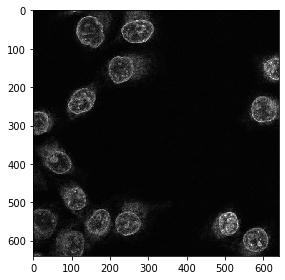

In [5]:
single_channel_gpu = image_gpu[:,:,1]

# the following line would fail
# imshow(single_channel_gpu)

# get single channel image back from GPU memory and show it
single_channel = cp.asnumpy(single_channel_gpu)
imshow(single_channel)

# we can also do this with a convenience function
def gpu_imshow(image_gpu):
  image = np.asarray(image_gpu)
  imshow(image)

## Image filtering and segmentation

The cucim developers have re-implemented many functions from sckit image, e.g. the [Gaussian blur filter](https://docs.rapids.ai/api/cucim/stable/api.html#cucim.skimage.filters.gaussian), [Otsu Thresholding](https://docs.rapids.ai/api/cucim/stable/api.html#cucim.skimage.filters.threshold_otsu) after [Otsu et al. 1979](https://ieeexplore.ieee.org/document/4310076), [binary erosion](https://docs.rapids.ai/api/cucim/stable/api.html#cucim.skimage.morphology.binary_erosion) and [connected component labeling](https://docs.rapids.ai/api/cucim/stable/api.html#cucim.skimage.measure.label).

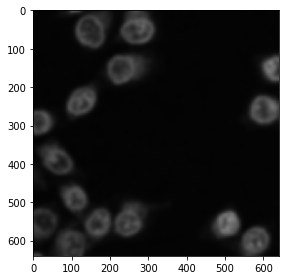

In [6]:
 from cucim.skimage.filters import gaussian

 blurred_gpu = gaussian(single_channel_gpu, sigma=5)

 gpu_imshow(blurred_gpu)

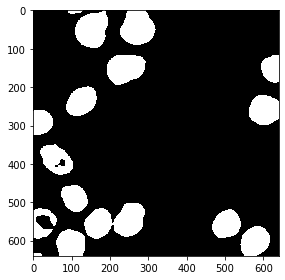

In [7]:
from cucim.skimage.filters import threshold_otsu

# determine threshold
threshold = threshold_otsu(blurred_gpu)

# binarize image by apply the threshold
binary_gpu = blurred_gpu > threshold

gpu_imshow(binary_gpu)

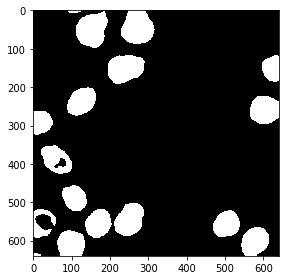

In [8]:
from cucim.skimage.morphology import binary_erosion, disk

eroded_gpu = binary_erosion(binary_gpu, selem=disk(2))

gpu_imshow(eroded_gpu)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


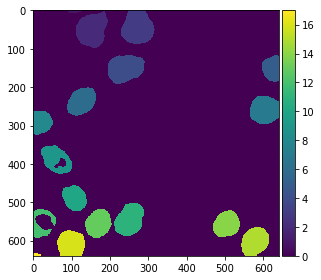

In [9]:
from cucim.skimage.measure import label

labels_gpu = label(eroded_gpu)

gpu_imshow(labels_gpu)

For visualization purposes, it is recommended to turn the label image into an RGB image, especially if you want to save it to disk.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  This is separate from the ipykernel package so we can avoid doing imports until


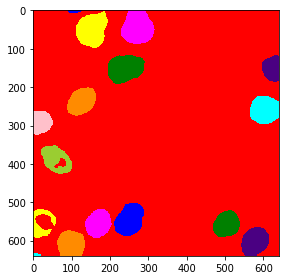

In [10]:
from cucim.skimage.color import label2rgb

labels_rgb_gpu = label2rgb(labels_gpu)

gpu_imshow(labels_rgb_gpu)

## Quantitative measurements

Also quantitative measurments using [regionprops_table](https://docs.rapids.ai/api/cucim/stable/api.html#cucim.skimage.measure.regionprops_table) have been implemented in cucim. A major difference is that you need to convert its result back to numpy if you want to continue processing on the CPU, e.g. using [pandas](https://pandas.pydata.org/).

In [11]:
from cucim.skimage.measure import regionprops_table 

table_gpu = regionprops_table(labels_gpu, intensity_image=single_channel_gpu, properties=('mean_intensity', 'area', 'solidity'))

table_gpu

{'area': array([ 238, 5833, 6006, 5679, 2534, 4200, 4655, 2662, 3846, 3350, 5005,
        2200, 3952, 3837, 4298, 4111,  139]),
 'mean_intensity': array([68.93277311, 54.14537974, 68.23676324, 59.95175207, 87.22178374,
        71.32666667, 74.37529538, 64.63561232, 58.93213729, 66.88656716,
        62.15684316, 50.51363636, 62.50177126, 92.24863174, 71.68776175,
        51.80345415, 72.3381295 ]),
 'solidity': array([0.97942387, 0.95842918, 0.97785738, 0.97964464, 0.98868513,
        0.98522167, 0.98727466, 0.99143389, 0.87171351, 0.98355843,
        0.96864718, 0.59945504, 0.98676654, 0.98510911, 0.98397436,
        0.97997616, 0.97887324])}

In [12]:
# The following line would fail.
# pd.DataFrame(table_gpu)

# We need to convert that table to numpy before we can pass it to pandas.
table = {item[0] : cp.asnumpy(item[1]) for item in table_gpu.items()}
pd.DataFrame(table)

,mean_intensity,area,solidity
0,68.932773,238,0.979424
1,54.145380,5833,0.958429
2,68.236763,6006,0.977857
3,59.951752,5679,0.979645
4,87.221784,2534,0.988685
5,71.326667,4200,0.985222
6,74.375295,4655,0.987275
7,64.635612,2662,0.991434
8,58.932137,3846,0.871714
9,66.886567,3350,0.983558
